# Testing DEMV on Compas dataset

In [8]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [9]:
data = pd.read_csv('data/compas.csv', index_col=0)

In [10]:
label = 'two_year_recid'
sensitive_vars = ['sex','race']
protected_group = {'sex':0, 'race': 0}

In [11]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

## Biased Data

In [12]:
model, biasmetrics = cross_val(pipeline, data, label, protected_group, sensitive_vars, positive_label=0)

In [13]:
print_metrics(biasmetrics)

Statistical parity:  -0.265  +-  0.041
Disparate impact:  0.614  +-  0.055
Zero one loss:  0.136  +-  0.051
F1 score:  0.667  +-  0.018
Accuracy score:  0.667  +-  0.018


## DEMV Data

In [14]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [15]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_vars, debiaser=demv, positive_label=0)

In [16]:
print_metrics(demv_metrics)

Statistical parity:  -0.104  +-  0.044
Disparate impact:  0.825  +-  0.067
Zero one loss:  0.099  +-  0.042
F1 score:  0.664  +-  0.016
Accuracy score:  0.664  +-  0.016


## Exponentiated Gradient

### Demographic parity

In [17]:
exp = ExponentiatedGradient(pipeline, DemographicParity(),
sample_weight_name="classifier__sample_weight")


In [18]:
model, exp_metrics = cross_val(exp, data, label, protected_group, sensitive_vars, exp=True, positive_label=0)

In [19]:
print_metrics(exp_metrics)

Statistical parity:  -0.018  +-  0.047
Disparate impact:  0.927  +-  0.04
Zero one loss:  0.093  +-  0.048
F1 score:  0.657  +-  0.017
Accuracy score:  0.658  +-  0.017


### Zero One Loss

In [20]:
constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
exp = ExponentiatedGradient(pipeline, constr,
                            sample_weight_name="classifier__sample_weight")


In [21]:
model, zol_metrics = cross_val(
    exp, data, label, protected_group, sensitive_vars, exp=True, positive_label=0)


In [22]:
print_metrics(zol_metrics)

Statistical parity:  -0.282  +-  0.051
Disparate impact:  0.592  +-  0.063
Zero one loss:  0.124  +-  0.033
F1 score:  0.666  +-  0.016
Accuracy score:  0.665  +-  0.016


## DEMV Evaluation

In [23]:
metrics = eval_demv(29, 116, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=0)

In [25]:
%load_ext autoreload
%autoreload 2

In [27]:
df = prepareplots(metrics,'compas')

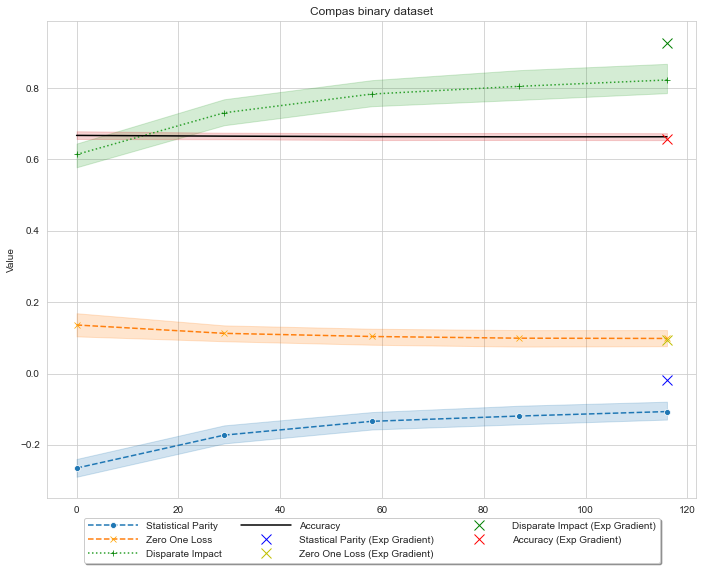

In [28]:
points = preparepoints(exp_metrics,demv.get_iters())
plot_metrics_curves(df, points, 'Compas binary dataset')

In [29]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 6167
Unprivileged group size: 3374
Percentage of unprivileged group: 54.710556186152104
Number of iterations: 116
